In [1]:
import zipfile
with zipfile.ZipFile("/content/data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
df_olist_customers = pd.read_csv('/content/data/data/olist_customers_dataset.csv')
df_order=pd.read_csv("/content/data/data/olist_orders_dataset.csv")
df_order_items=pd.read_csv("/content/data/data/olist_order_items_dataset.csv")
df_products=pd.read_csv("/content/data/data/olist_products_dataset.csv")
df_sellers=pd.read_csv("/content/data/data/olist_sellers_dataset.csv")
df_review=pd.read_csv("/content/data/data/olist_order_reviews_dataset.csv")


In [45]:
df_merged = pd.merge(df_order, df_order_items, on='order_id')
df_merged = pd.merge(df_merged, df_products, on='product_id')
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['Month'] = df_merged['order_purchase_timestamp'].dt.month
df_merged['Year'] = df_merged['order_purchase_timestamp'].dt.year
df_revenue = df_merged.groupby(['Year', 'Month'])['price'].sum().reset_index()
fig = px.bar(df_revenue, x='Month', y='price', color='Year', barmode="group",
             labels={'price': 'Turnover', 'Month': 'Month'},
             title='Turnover per month')
fig.show()


We can see the products sold for each month and thus show that the months with the most sales are May and August

This is the turnover realized per order status

In [23]:
merged_df = pd.merge(df_order, df_order_items, on='order_id')
revenue_by_status = merged_df.groupby('order_status')['price'].sum()
print("Turnover per order status:\n", revenue_by_status)


Turnover per order status:
 order_status
approved            209.60
canceled          95235.27
delivered      13221498.11
invoiced          61526.37
processing        60439.22
shipped          150727.44
unavailable        2007.69
Name: price, dtype: float64


We can make an analyse of quantity of products solded by categories of products

In [27]:
merged_df = pd.merge(df_order_items, df_products, on='product_id')
product_category_sales = merged_df.groupby('product_category_name')['product_id'].count()
fig = px.pie(product_category_sales, values='product_id', names=product_category_sales.index,
             title='Quantity of Products Sold by Category')

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

We can make the top-ten products

In [25]:
merged_df = pd.merge(df_order_items, df_products, on='product_id')
merged_df = pd.merge(merged_df, df_order, on='order_id')
product_revenue = merged_df.groupby('product_id')['price'].sum().reset_index()
product_revenue = product_revenue.rename(columns={'price': 'TotalRevenue'})
top_10_products = product_revenue.sort_values('TotalRevenue', ascending=False).head(10)
top_10_products = pd.merge(top_10_products, df_products[['product_id', 'product_category_name']], on='product_id', how='left')
print("Top 10 Products by Total Revenue:")
print(top_10_products[['product_id', 'product_category_name', 'TotalRevenue']])


Top 10 Products by Total Revenue:
                         product_id   product_category_name  TotalRevenue
0  bb50f2e236e5eea0100680137654686c            beleza_saude      63885.00
1  6cdd53843498f92890544667809f1595            beleza_saude      54730.20
2  d6160fb7873f184099d9bc95e30376af                     pcs      48899.34
3  d1c427060a0f73f6b889a5c7c61f2ac4  informatica_acessorios      47214.51
4  99a4788cb24856965c36a24e339b6058         cama_mesa_banho      43025.56
5  3dd2a17168ec895c781a9191c1e95ad7  informatica_acessorios      41082.60
6  25c38557cf793876c5abdd5931f922db                   bebes      38907.32
7  5f504b3a1c75b73d6151be81eb05bdc9              cool_stuff      37733.90
8  53b36df67ebb7c41585e8d54d6772e08      relogios_presentes      37683.42
9  aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao      37608.90


This is the number of customers by month

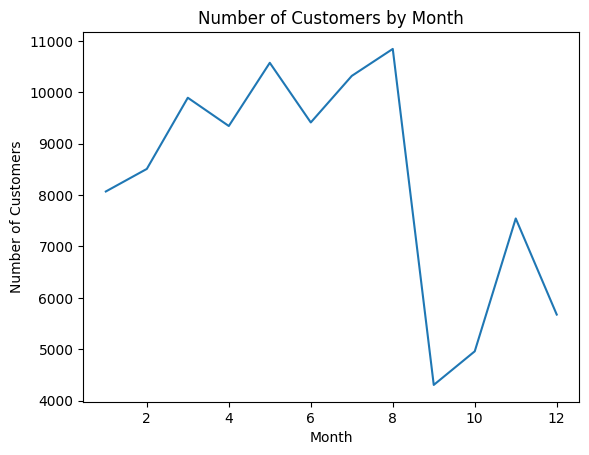

In [28]:
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])
df_order['Month'] = df_order['order_purchase_timestamp'].dt.month
customer_by_month = df_order.groupby('Month')['customer_id'].nunique().reset_index()
customer_by_month = customer_by_month.rename(columns={'customer_id': 'Number of Customers'})
plt.plot(customer_by_month['Month'], customer_by_month['Number of Customers'])
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.show()

We can see the average basket value accross the satisfaction ratings

In [70]:
merged_df = pd.merge(df_order, df_order_items, on='order_id')
merged_df = pd.merge(merged_df, df_review, on='order_id')
average_basket_by_rating = merged_df.groupby('review_score')['price'].mean()
fig = go.Figure()
for rating, value in average_basket_by_rating.items():
  fig.add_trace(go.Bar(x=[rating], y=[value], name=f'Rating {rating}'))
fig.update_layout(
    title='Average Basket Value Across Satisfaction Rating',
    xaxis_title='Satisfaction Rating',
    yaxis_title='Average Basket Value',
    barmode='group'  # Display bars clustered together
)
fig.show()


We can make two tests about two hypothesis.
1. The product category name has an impact on the order value
2. The satisfaction rating has an impact on the order value

In [76]:
merged_df = pd.merge(df_order, df_order_items, on='order_id')
merged_df = pd.merge(merged_df, df_products, on='product_id')
average_order_by_category = merged_df.groupby('product_category_name')['price'].mean()
from scipy import stats
f_statistic, p_value = stats.f_oneway(*[group for name, group in merged_df.groupby('product_category_name')['price']])
print("F-statistic:", f_statistic)
print("P-value:", p_value)
alpha = 0.05


F-statistic: 192.00541633281054
P-value: 0.0


This analyse shows that the products category name has a real impact on the order value.

In [78]:
merged_df = pd.merge(df_order, df_order_items, on='order_id')
merged_df = pd.merge(merged_df, df_review, on='order_id')
average_order_by_rating = merged_df.groupby('review_score')['price'].mean()
f_statistic, p_value = stats.f_oneway(*[group for name, group in merged_df.groupby('review_score')['price']])
print("F-statistic:", f_statistic)
print("P-value:", p_value)
alpha = 0.05


F-statistic: 14.22375912105448
P-value: 1.3102761612389787e-11


We can confirm the hypothesis. The satisafaction ratings have real impacts on the order value